In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), mismatched flags (16))


In [52]:
solver_args = Dict(:adaptive => false, :dt => 0.01f0)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [53]:
spk_args = SpikingArgs(threshold = 0.001f0,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 10, use_cuda = true)

Args(0.001, 128, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

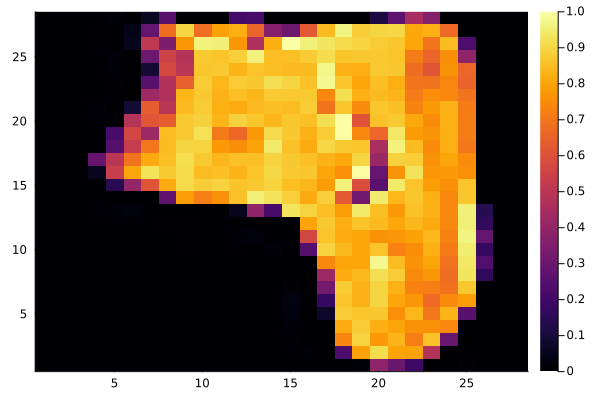

In [15]:
heatmap(x0[:,:,1])

# Test conventional network

In [16]:
model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            Conv((16, 16), 1 => 3, relu),
            Conv((8, 8), 3 => 1, relu),
            FlattenLayer(),
            Dense(36 => 128, relu),
            Dense(128 => 10),
            softmax)

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#25),
    layer_3 = Conv((16, 16), 1 => 3, relu),  # 771 parameters
    layer_4 = Conv((8, 8), 3 => 1, relu),  # 193 parameters
    layer_5 = FlattenLayer{Nothing}(nothing),
    layer_6 = Dense(36 => 128, relu),   # 4_736 parameters
    layer_7 = Dense(128 => 10),         # 1_290 parameters
    layer_8 = WrappedFunction(softmax),
)         # Total: 8_558 parameters,
          #        plus 0 states.

In [17]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.019709477 0.0077816104 … 0.05482017 -0.08519609; -0.14134635 0.20817417 … 0.09868311 0.17127244; … ; -0.12946782 0.023861565 … -0.13425288 -0.19576402; 0.13110001 0.05310778 … 0.065689325 -0.13362738;;;; 0.15503614 -0.17867574 … -0.15539703 0.05237471; -0.045117833 -0.033451576 … -0.10569792 0.05006388; … ; 0.20915674 0.10383065 … -0.19610864 -0.039417222; 0.0066004097 0.08147644 … -0.11394326 -0.18828012;;;; -0.178612 0.08852646 … -0.07514592 0.18356745; -0.19098079 -0.19624312 … 0.21617825 0.037872236; … ; 0.052916326 0.07858618 … -0.15753508 0.15217651; -0.054194387 0.1918815 … 0.19596435 -0.07114898], bias = Float32[-0.027953401, 0.02774784, 0.031258054]), layer_4 = (weight = Float32[-0.20838591 -0.17065153 … 0.0936847

In [18]:
yp, _ = model(x0, ps, st);

In [19]:
yp |> size

(10, 128)

In [20]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [21]:
loss_function(x0, y0, model, ps, st)

2.2924886f0

In [22]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[2.2924886f0, 2.3086882f0, 2.313415f0, 2.3001928f0, 2.2781935f0, 2.2996035f0, 2.272059f0, 2.2726004f0, 2.3019688f0, 2.2817464f0  …  0.41058958f0, 0.36418897f0, 0.287885f0, 0.5359343f0, 0.45733994f0, 0.3686526f0, 0.4165424f0, 0.36712688f0, 0.28636062f0, 0.28851816f0], (layer_1 = (bias = Float32[0.21947521 0.294681 … 0.5475979 0.2504686; -0.17910196 0.5438807 … 0.2107838 0.17948864; … ; 0.025754819 0.14459594 … -0.020706886 -0.2778994; 0.002324258 0.012446465 … -0.2724811 0.06770789;;;], scale = Float32[0.77145994 0.70553297 … 0.4500652 0.7484901; 1.1716372 0.45360482 … 0.7597494 0.84158134; … ; 0.9599388 0.7934035 … 1.0024235 1.232392; 1.0025454 0.9682551 … 1.2538365 0.94167393;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[0.013696819 -0.08057692 … -0.0067489133 -0.23863013; -0.20532954 0.2511773 … 0.0011012292 -0.0139056975; … ; -0.21770431 0.06722829 … -0.20153742 -0.48522663; 0.17328675 0.0472742 … 0.023944583 -0.59602714;;;; 0.32540625 -0.17245503 … -0.3628573 0.0186

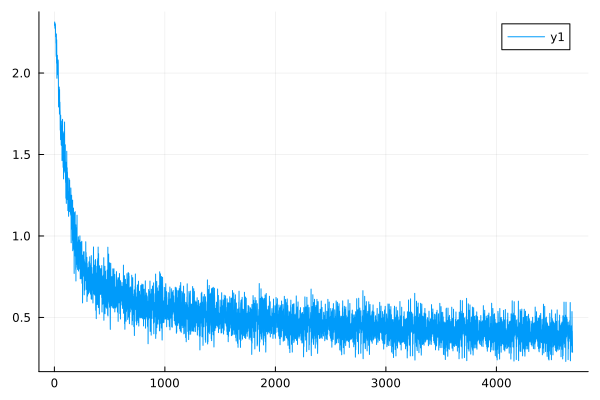

In [23]:
plot(losses)

In [24]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [25]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [26]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.1052

In [27]:
test(model, test_loader, pst, stt)

0.837

# Test Phasor network

In [28]:
import .PhasorNetworks: default_bias

In [29]:
p_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => 128, soft_angle),
            PhasorDense(128 => 10, soft_angle),
            )

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#27),
    layer_3 = WrappedFunction(#28),
    layer_4 = WrappedFunction(#29),
    layer_5 = PhasorConv(
        conv = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),  # 6 parameters
    ),
    layer_6 = PhasorConv(
        conv = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),  # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        dense = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_9 = PhasorDense(
        dense = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)         # Total: 8_700 parameters,
          #        plus 0 states.

In [30]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (conv = (weight = Float32[-0.036542863 -0.027199361 … 0.017244818 0.041950304; -0.0710592 -0.06512198 … 0.06375972 -0.034112442; … ; 0.05917423 -0.06103529 … 0.022629235 -0.102332935; -0.049921226 0.0090688495 … -0.018641477 0.025165116;;;; -0.03195702 -0.10596771 … 0.07685449 -0.009230882; 0.0756033 -0.043595277 … -0.07175595 0.0766504; … ; 0.069335274 0.010884398 … 0.024393551 -0.019245291; 0.070619956 -0.014703505 … -0.08407562 0.046545427;;;; -0.053264778 -0.035796568 … 0.08875957 0.042897023; 0.09749821 -0.034223627 … 0.09494364 -0.0505918; … ; 0.06282602 -0.086941965 … 0.073650464 -0.0104130125; -0.010780476 0.017408967 … 0.030074108 0.09104783],), bias = (bias_real = Float32[1.0;;; 1.0;;; 

In [31]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[0.63249004 0.94771814 … 0.6435195 -0.30035084; 0.16128106 0.086146906 … 0.28116328 -0.015108113; … ; -0.095289975 0.1713489 … 0.15488133 0.23422575; -0.13500385 0.121281095 … -0.15815946 0.10183413], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (conv = NamedTuple(), bias = NamedTuple()), layer_6 = (conv = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = (dense = NamedTuple(), bias = NamedTuple()), layer_9 = (dense = NamedTuple(), bias = NamedTuple())))

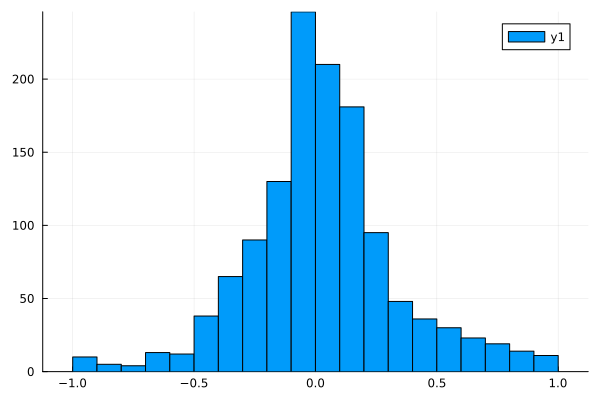

In [32]:
histogram(cdev(vec(yp0)))

In [33]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = quadrature_loss(y_pred, y_onehot) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [34]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

0.40312797f0

In [35]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CUDA GPU


(Any[0.40312797f0, 0.21647921f0, 0.1825364f0, 0.16342145f0, 0.13806598f0, 0.121344656f0, 0.11909643f0, 0.11014837f0, 0.10874164f0, 0.105313815f0  …  0.02861163f0, 0.026533639f0, 0.02053726f0, 0.028852735f0, 0.029226037f0, 0.028671682f0, 0.03231944f0, 0.030621514f0, 0.02421986f0, 0.028034573f0], (layer_1 = (bias = Float32[0.30486348 0.05857782 … 0.18531252 0.34211162; 0.18324038 0.22881395 … 0.12565936 0.35038325; … ; -0.0018363611 -0.26827094 … 0.21400674 0.25846675; -0.42895296 -0.048076097 … 0.17403725 0.108194806;;;], scale = Float32[0.68748546 0.9432877 … 0.79145294 0.6594829; 0.81614465 0.7682812 … 0.86451226 0.6393445; … ; 1.0079291 1.2727439 … 0.7436873 0.7170251; 1.429601 1.0475905 … 0.8140594 0.88293713;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (conv = (weight = Float32[-0.15405266 -0.059170596 … -0.066074125 -0.02090955; -0.20333861 -0.019601306 … 0.051426318 0.042282373; … ; -0.0444382 -0.037835296 … 0.19023661 -0.09172347; -0.13

In [36]:
ps_train_f.layer_5.bias

(bias_real = Float32[1.0909692;;; 1.3611256;;; 1.1042564], bias_imag = Float32[0.3339234;;; 0.23017614;;; 0.3717954])

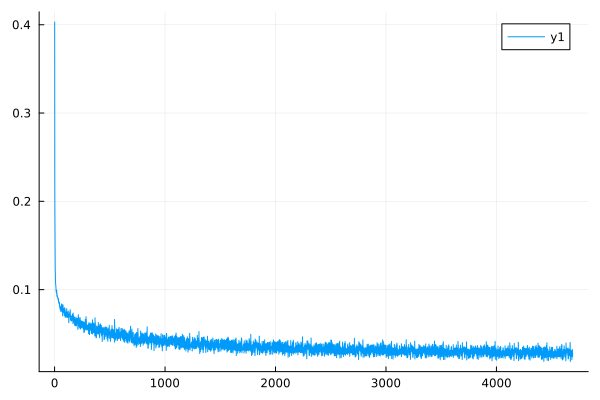

In [37]:
#plot(losses)
plot(losses_f)

In [38]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_quadrature(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [68]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.8222

# Test spiking behavior

In [73]:
spk_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => 128, soft_angle),
            PhasorDense(128 => 10, soft_angle),
            )
            

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#41),
    layer_3 = WrappedFunction(#42),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorConv(
        conv = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),  # 6 parameters
    ),
    layer_6 = PhasorConv(
        conv = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),  # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        dense = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),     # 256 parameters
    ),
    layer_9 = PhasorDense(
        dense = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),      # 20 parameters
    ),
)     

In [74]:
spk_args.solver_args[:dt]

0.01f0

In [75]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (conv = (weight = Float32[-0.085069805 -0.044437263 … 0.06319488 0.059628762; -0.052430473 0.035697136 … -0.0011131279 -0.07720943; … ; 0.066650435 0.069611385 … 0.012780627 -0.03628883; 0.0085978 0.016631298 … -0.028980428 0.051370874;;;; -0.0033142583 0.041363806 … 0.09406875 0.093330055; 0.03800819 0.03429196 … 0.081977576 0.06510472; … ; 0.031248327 -0.05953111 … 0.06753596 -0.015924517; -0.07572954 -0.026237775 … -0.057280786 -0.03373766;;;; -0.009930153 0.029398544 … 0.066513866 -0.073430516; 0.074971475 -0.0034648958 … -0.031174487 0.03694565; … ; -0.06892467 -0.038133107 … 0.039402798 0.03817226; -0.06323528 0.07152924 … 0.027617063 0.032345288],), bias = (bias_real = Float32[1.0;;; 1.0;;

In [76]:
typeof(x0)

Array{Float32, 3}

In [77]:
ps0t.layer_5.conv

(weight = Float32[-0.085069805 -0.044437263 … 0.06319488 0.059628762; -0.052430473 0.035697136 … -0.0011131279 -0.07720943; … ; 0.066650435 0.069611385 … 0.012780627 -0.03628883; 0.0085978 0.016631298 … -0.028980428 0.051370874;;;; -0.0033142583 0.041363806 … 0.09406875 0.093330055; 0.03800819 0.03429196 … 0.081977576 0.06510472; … ; 0.031248327 -0.05953111 … 0.06753596 -0.015924517; -0.07572954 -0.026237775 … -0.057280786 -0.03373766;;;; -0.009930153 0.029398544 … 0.066513866 -0.073430516; 0.074971475 -0.0034648958 … -0.031174487 0.03694565; … ; -0.06892467 -0.038133107 … 0.039402798 0.03817226; -0.06323528 0.07152924 … 0.027617063 0.032345288],)

In [78]:
ps0t.layer_5.bias

(bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])

In [79]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039  …  21.490742, 21.00195, 21.94676, 21.502714, 21.00117, 21.591745, 21.512354, 21.00113, 21.492344, 21.00565], (10, 128), 1280, 1.0f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = Name

In [80]:
ys0.train.shape

(10, 128)

In [81]:
ys0.train

SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039  …  21.490742, 21.00195, 21.94676, 21.502714, 21.00117, 21.591745, 21.512354, 21.00113, 21.492344, 21.00565], (10, 128), 1280, 1.0f0)

In [82]:
ys0.t_span

(0.0f0, 20.0f0)

In [83]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    acc = []
    n_phases = []
    num = 0

    n_batches = length(data_loader)

    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
            y = gdev(1.0f0 .* onehotbatch(y, 0:9))
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        append!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    acc = sum(reshape(acc, :, n_batches), dims=2) ./ num
    return acc
end

fmnist_spiking_accuracy (generic function with 1 method)

In [84]:
spk_a = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

20×1 Matrix{Float64}:
 0.1
 0.1
 0.1
 0.2605
 0.4276
 0.5547
 0.6892
 0.7514
 0.776
 0.7874
 0.7942
 0.7987
 0.8017
 0.8049
 0.8099
 0.8095
 0.8106
 0.8112
 0.8107
 0.2686

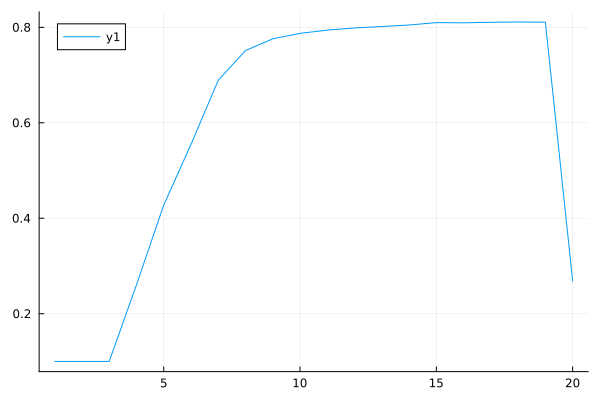

In [85]:
plot(spk_a)